In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from decimal import Decimal, getcontext
import math

from functools import lru_cache

# Задача 1. Интеграл через квадратуру на разностных схемах.
#### Рассчитать с машинной точностью интеграл с неопределенностью $\int\limits_{-1}^{1}{\frac{\sin{x/2}}{e^x-1}dx}$ квадратурой на разностных схемах.

In [2]:
###############################################################################
#  1) Вспомогательные функции для разностных квадратур                        #
###############################################################################
getcontext().prec = 100  # повышенная точность для Decimal

@lru_cache(None)
def factorial_dec(n: int) -> Decimal:
    if n < 0:
        raise ValueError("Negative factorial not defined")
    if n == 0 or n == 1:
        return Decimal(1)
    return Decimal(n) * factorial_dec(n - 1)

@lru_cache(None)
def comb_dec(n: int, k: int) -> Decimal:
    if k < 0 or k > n:
        return Decimal(0)
    return factorial_dec(n) / (factorial_dec(k) * factorial_dec(n - k))

@lru_cache(None)
def D(n: int, j: int) -> Decimal:
    """
    Вычисляет D_n^(j) по заданной рекуррентной формуле (см. теорию).
    """
    if j == 0:
        return Decimal(1)
    # "прогреваем" кэш:
    _ = D(n, j-1)
    return _compute_all_D_up_to(n, j)[j]

@lru_cache(None)
def _compute_all_D_up_to(n: int, J: int):
    results = [Decimal(0)]*(J+1)
    results[0] = Decimal(1)
    for j in range(J):
        s = Decimal(0)
        for k in range(n + 2*j + 1):
            for l in range(j+1):
                val = (
                    Decimal((-1)**k)
                    * results[l]
                    * comb_dec(n+2*l, k - (j - l))
                    * Decimal((n + 2*j - 2*k)**(n + 2*j + 2))
                    / (Decimal(2)**(n + 2*j + 2) * factorial_dec(n + 2*j + 2))
                )
                s += val
        # Финальная формула берёт только s, без + results[j].
        results[j+1] = s
    return results

@lru_cache(None)
def A(k: int, n: int, m: int) -> Decimal:
    """
    A_{k,n}^m = sum_{l=0}^m [ (-1)^(k-m) * D_n^(l) * C_{n+2l}^{k - m + l} ].
    """
    s = Decimal(0)
    sign = Decimal((-1)**(k - m))
    for l in range(m+1):
        s += (
            sign
            * D(n, l)
            * comb_dec(n+2*l, k - m + l)
        )
    return s

@lru_cache(None)
def W_list(m: int):
    """
    Коэффициенты W_k^m (k=0..2m) в Decimal.

      W_k^m = sum_{n=0}^m [ A_{k,2n}^{m-n} / (2^(2n)*(2n+1)!) ].
    """
    result = []
    for k in range(2*m + 1):
        s = Decimal(0)
        for n_ in range(m+1):
            a_val = A(k, 2*n_, m - n_)
            denom = (Decimal(2)**(2*n_) * factorial_dec(2*n_+1))
            s += a_val / denom
        result.append(s)
    return result

def build_function_values_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Центральная сетка: x_j = a + (j+0.5)*h, j=-m..(J-1+m).
    Возвращает (y_values, h, calls).
    """
    h = (b - a)/J
    values = []
    for j_real in range(-m, (J - 1) + m + 1):
        x_val = a + (j_real + 0.5)*h
        values.append(f(x_val))
    calls = len(values)
    return values, h, calls

def integrate_by_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Разностная (дифференсная) квадратура порядка 2m:
      ∫[a..b] f(x) dx ≈ h Σ_j Σ_k [ W_{m-k} * f( x_{j+k} ) ].
    Возвращает (approx, calls).
    """
    y_values, h, calls = build_function_values_diff_scheme(f, a, b, J, m)
    W_dec = W_list(m)
    W = [float(wd) for wd in W_dec]
    
    offset = m
    total_sum = 0.0
    for j in range(J):
        loc_sum = 0.0
        for k in range(-m, m+1):
            idx = (j + k) + offset
            loc_sum += W[m - k] * y_values[idx]
        total_sum += loc_sum
    return (h * total_sum, calls)

###############################################################################
#        2) Метод Симпсона (классический) с заданным числом вызовов f         #
###############################################################################

def build_function_values_simpson(f, a: float, b: float, n: int):
    h = (b - a)/n
    y = [f(a + i*h) for i in range(n+1)]
    return y, h

def simpson_by_calls(f, a: float, b: float, calls: int):
    """
    Метод Симпсона «под число вызовов calls».
    Если (calls-1) нечётно, уменьшаем n на 1.
    Если n < 2, берём n=2.
    Возвращает (approx, real_calls).
    """
    n = calls - 1
    if n % 2 == 1:
        n -= 1
    if n < 2:
        n = 2
    
    y, h = build_function_values_simpson(f, a, b, n)
    real_calls = n + 1
    
    # Классическая формула Симпсона
    s_odd = 0.0
    s_even = 0.0
    for i in range(1, n, 2):
        s_odd += y[i]
    for i in range(2, n, 2):
        s_even += y[i]
    simpson_approx = (h/3.0)*(y[0] + y[n] + 4.0*s_odd + 2.0*s_even)

    return (simpson_approx, real_calls)

In [3]:
def main():
    def f1(x: float) -> float:
        if (x == 0):
            return 0.5
        return math.sin(x / 2.) / (math.exp(x) - 1.)

    a1, b1 = -1., 1.0
    eps = 1e-16 # требуемая точность
   
    for m in [3, 4, 5, 6, 7, 8, 9, 10, 20]:
        prev, diff_calls = integrate_by_diff_scheme(f1, a1, b1, 2, m)
        J = 3
        new, diff_calls = integrate_by_diff_scheme(f1, a1, b1, J, m)
        
        while (np.abs(new - prev) > eps):
            prev = new
            J += 1
            new, diff_calls = integrate_by_diff_scheme(f1, a1, b1, J, m)
        
        print(f"With m = {m}: J = {J}, calls={diff_calls:2d} res = {new:.16f}")

if __name__ == "__main__":
    main()

With m = 3: J = 35, calls=41 res = 1.0130392362326253
With m = 4: J = 24, calls=32 res = 1.0130392362326259
With m = 5: J = 14, calls=24 res = 1.0130392362326262
With m = 6: J = 11, calls=23 res = 1.0130392362326264
With m = 7: J = 11, calls=25 res = 1.0130392362326262
With m = 8: J = 8, calls=24 res = 1.0130392362326262
With m = 9: J = 11, calls=29 res = 1.0130392362326264
With m = 10: J = 6, calls=26 res = 1.0130392362326262
With m = 20: J = 7, calls=47 res = 1.0130392362326262


# Задача 2. Постоянная Эйлера-Маскерони методом прямой сшивки
#### Используя методику прямой сшивки при взятии сумм рядов, рассчитать постоянную Эйлера-Маскерони с ошибкой в 13 знаке по формуле $\gamma_E = \lim _{n \rightarrow \infty}(1+1 / 2+1 / 3+1 / 4+\ldots+1 / n-\ln n)$

$\gamma_E = -\ln(j_m + 1/2) + \sum_{j = 1}^{j_m - m}\frac{1}{j} +\sum_{j=j_m-m+1}^{j_m+m}\left(1-I_{j+m-j_m-1}^m\right)/j +O\left(1 / j_{\mathrm{s}}^{2 m+2}\right)$

In [4]:
def I_list(m):
    W_dec = W_list(m)
    result = []
    I0 = Decimal(0)
    for k in range(2*m):
        I0 += W_dec[2*m - k]
        result.append(I0)
    return result

def Euler_Mascheroni_constant(j_m, m):
    sum = Decimal(0)
    for j in range(1, j_m - m + 1):
        sum += Decimal(1 / j)
    
    I = I_list(m)
    for j in range(j_m - m + 1, j_m + m + 1, 1):
        sum += (Decimal(1) - I[j + m - j_m - 1]) * Decimal(1 / j)
        
    return float(Decimal(-math.log(j_m + 0.5)) + sum)

In [6]:
eps = 1e-16

for m in [4, 5, 6, 7, 8, 9, 10, 20]:
    j_m = m
    prev = Euler_Mascheroni_constant(j_m, m)
    j_m += 1
    new = Euler_Mascheroni_constant(j_m, m)

    while (np.abs(new - prev) > eps):
        prev = new
        j_m += 1
        new = Euler_Mascheroni_constant(j_m, m)

    print(f"With m = {m}: j_m = {j_m} res = {new:.14f}")

With m = 4: j_m = 37 res = 0.57721566490153
With m = 5: j_m = 33 res = 0.57721566490153
With m = 6: j_m = 24 res = 0.57721566490153
With m = 7: j_m = 24 res = 0.57721566490153
With m = 8: j_m = 24 res = 0.57721566490153
With m = 9: j_m = 19 res = 0.57721566490153
With m = 10: j_m = 24 res = 0.57721566490153
With m = 20: j_m = 24 res = 0.57721566490153


# Задача 3. Сумма ряда
#### Вычислить сумму ряда $\sum_{n=1}^{\infty} \frac{n^2+1}{n^4+n^2+1} \operatorname{сos}(2 n)$ с точностью $\varepsilon=10^{-6}$, применяя метод Куммера.

Для точности $10^{-6}$ нужно слагаемых ряда $c_k$:

In [8]:
(10**6 / 5)**0.2 - 1

10.486983549970352

In [13]:
S = 0
for n in range(1, 11):
    S += math.cos(2. * n) / (n**2 * (n**4 + n**2 + 1.))
res = math.pi**2 / 6 - math.pi + 1 - S
print(res)

-0.3512657639505239


# Задача 4. Предел
#### Взять предел $\lim _{x \rightarrow 0} \frac{y(x)-1}{x}$,  где $\begin{split}
y(x)= \begin{cases}\operatorname{ch} \sqrt{|x|}, & x>0 \\ \cos \sqrt{|x|}, & x<0\end{cases}
\end{split}$

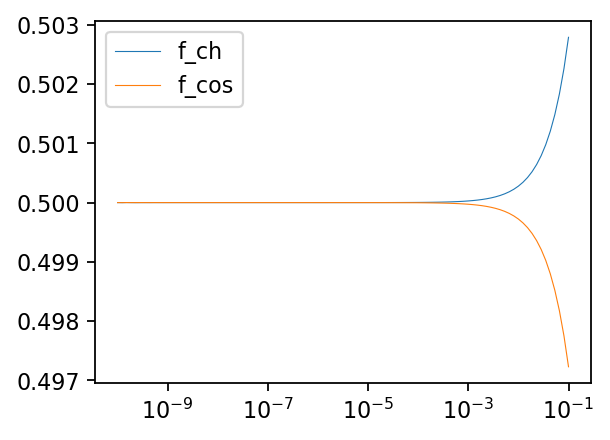

0.500000041358516
0.5000000413701877


In [52]:
def y_val(f, j, dx):
    if (j >= 0):
        return f((2*j + 1) * dx / 2.)
    else:
        return f(-(2*j - 1) * dx / 2.)

def lim(f, N: int, m: int, dx: float):
    s = 0
    for n in range(N):
        for k in range(2*m + n%2):
            s += float(A(k, n, m - int((n - n%2)/2))) * (-1)**n / 4**n / float(factorial_dec(n)) * y_val(f, 2*m + n%2 - 2*k, dx)
    return s

def y_ch(x):
    return (np.cosh(np.abs(x)**0.5) - 1) / x
def f_ch(x):
    if (x > 0):
        return y_ch(x)
    else:
        return y_ch(-x)

def y_cos(x):
    return (np.cos(np.abs(x)**0.5) - 1) / x
def f_cos(x):
    if (x < 0):
        return y_cos(x)
    else:
        return y_cos(-x)

xs = np.logspace(-10, -1, 100)
ys_ch = np.array([lim(f_ch, 5, 20, dx) for dx in xs])
ys_cos = np.array([lim(f_cos, 5, 20, dx) for dx in xs])

figure(figsize=(4, 3), dpi=160)
plt.plot(xs, ys_ch, '-', label='f_ch', lw=0.5)
#plt.plot(xs, lim(f_cos, 5, 20, xs), '-', label='f_cos', lw=0.5)
plt.plot(xs, ys_cos, '-', label='f_cos', lw=0.5)

plt.legend(loc = 'best')
plt.xscale('log')
plt.show()
print(lim(f_cos, 5, 20, 1e-10))
print(lim(f_ch, 5, 20, 1e-10))